In [1]:
# Gun Detection Lab: Detecting Guns in Images using PyTorch and Faster R-CNN
# Use GPU: Runtime=>Change Runtime type=>T4 GPU

# Step 1: Install Dependencies
!pip install torch torchvision matplotlib opencv-python pycocotools py7zr requests

# Step 2: Import Libraries
import os
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
import py7zr
import requests

# Step 3: Download and Extract Dataset
dataset_url = "https://github.com/frankwxu/AI4DigitalForensics/raw/main/lab02_Gun_detection_fasterRCNN/data/data.7z"
dataset_path = "/content/data.7z"
extracted_path = "/content/dataset"

# Download the dataset
!wget -O {dataset_path} {dataset_url}

# Extract the dataset
with py7zr.SevenZipFile(dataset_path, mode='r') as z:
    z.extractall(path=extracted_path)

# Define paths to images, labels, and custom test images
images_dir = os.path.join(extracted_path, "Images")  # Folder name is "Images"
labels_dir = os.path.join(extracted_path, "Labels")  # Folder name is "Labels"
custom_test_images_dir = os.path.join(extracted_path, "our_test_images")  # New folder for custom test images



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 22.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.2/

In [2]:
# Step 4: Create Custom Dataset Class
class GunDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root, "Images"))))
        self.labels = list(sorted(os.listdir(os.path.join(root, "Labels"))))

    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        label_path = os.path.join(self.root, "Labels", self.labels[idx])

        img = Image.open(img_path).convert("RGB")
        target = self.parse_annotation(label_path)

        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

    def parse_annotation(self, label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
            num_guns = int(lines[0].strip())  # Number of guns in the image
            bboxes = []
            labels = []

            # Parse each bounding box
            for i in range(1, num_guns + 1):
                bbox = list(map(int, lines[i].strip().split()))  # Bounding box (xmin, ymin, xmax, ymax)
                bboxes.append(bbox)
                labels.append(1)  # All objects are labeled as "Gun" (class 1)

        return {
            'boxes': torch.tensor(bboxes, dtype=torch.float32),
            'labels': torch.tensor(labels, dtype=torch.int64)
        }

    def display_image_with_annotations(self, idx):
        """
        Display an image with its annotations (bounding boxes).
        """
        # Load the image and annotation
        img_path = os.path.join(self.root, "Images", self.imgs[idx])
        label_path = os.path.join(self.root, "Labels", self.labels[idx])

        if not os.path.exists(img_path) or not os.path.exists(label_path):
            print(f"Image or annotation file not found for index {idx}")
            return

        img = Image.open(img_path).convert("RGB")
        draw = ImageDraw.Draw(img)

        # Parse the annotations
        target = self.parse_annotation(label_path)
        bboxes = target['boxes'].cpu().numpy()

        # Draw bounding boxes on the image
        for bbox in bboxes:
            xmin, ymin, xmax, ymax = bbox
            draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=3)

        # Display the image with annotations
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.title(f"Image: {self.imgs[idx]} with Annotations")
        plt.axis('off')
        plt.show()

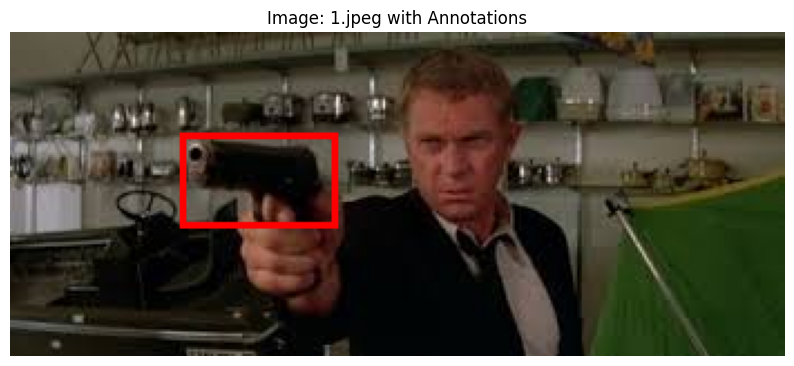

In [3]:
# Step 5: Define Data Transforms
def get_transform(train):
    transforms = []
    transforms.append(torchvision.transforms.ToTensor())
    if train:
        transforms.append(torchvision.transforms.RandomHorizontalFlip(0.5))
    return torchvision.transforms.Compose(transforms)

# Step 6: Load Dataset and Display the first image
train_dataset = GunDataset(extracted_path, get_transform(train=True))
test_dataset = GunDataset(extracted_path, get_transform(train=False))

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=lambda x: tuple(zip(*x)))

# Display the first image in the training dataset with its annotations
train_dataset.display_image_with_annotations(0)

In [4]:
# Step 7: Load Pre-trained Faster R-CNN Model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Replace the classifier head for custom classes
num_classes = 2  # Background + Gun
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:02<00:00, 64.6MB/s]


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [5]:
# Step 8: Define Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# Step 9: Train the Model
def train_one_epoch(model, optimizer, data_loader, device, epoch):
    model.train()
    for i, (images, targets) in enumerate(data_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if i % 10 == 0:
            print(f"Iteration {i}, Loss: {losses.item()}")


In [6]:
# Train for 1 epochs and incerase the number will improve performance
num_epochs = 1
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    train_one_epoch(model, optimizer, train_loader, device, epoch)


Epoch 1/1
Iteration 0, Loss: 0.8547430634498596
Iteration 10, Loss: 0.11103399842977524
Iteration 20, Loss: 0.1575157642364502
Iteration 30, Loss: 0.24550382792949677
Iteration 40, Loss: 0.3896343410015106
Iteration 50, Loss: 0.25790077447891235
Iteration 60, Loss: 0.13303083181381226
Iteration 70, Loss: 0.2661501169204712
Iteration 80, Loss: 0.210196390748024
Iteration 90, Loss: 0.1938142031431198
Iteration 100, Loss: 0.7571224570274353
Iteration 110, Loss: 0.17473864555358887
Iteration 120, Loss: 0.17186081409454346
Iteration 130, Loss: 0.14213237166404724
Iteration 140, Loss: 0.29072222113609314
Iteration 150, Loss: 0.17986759543418884
Iteration 160, Loss: 0.17462462186813354


In [7]:
# Step 10: Save the Trained Model
model_save_path = "/content/gun_detection_model_30epoch.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/gun_detection_model_30epoch.pth


In [8]:
# Step 11: Evaluate the Model
def evaluate_model(model, data_loader, device, iou_threshold=0.5, score_threshold=0.5):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, targets in data_loader:
            images = list(image.to(device) for image in images)
            outputs = model(images)

            for output, target in zip(outputs, targets):
                # Ground truth labels and boxes
                gt_boxes = target['boxes'].cpu().numpy()
                gt_labels = target['labels'].cpu().numpy()

                # Predicted labels, boxes, and scores
                pred_boxes = output['boxes'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()

                # Filter predictions by confidence threshold
                valid_preds = pred_scores > score_threshold
                pred_boxes = pred_boxes[valid_preds]
                pred_labels = pred_labels[valid_preds]

                # Match predictions to ground truth using IoU
                matched_gt_indices = set()  # To track matched ground truth boxes
                for pred_box, pred_label in zip(pred_boxes, pred_labels):
                    best_iou = 0
                    best_gt_idx = -1

                    # Compute IoU between the predicted box and all ground truth boxes
                    for gt_idx, gt_box in enumerate(gt_boxes):
                        iou = compute_iou(pred_box, gt_box)
                        if iou > best_iou:
                            best_iou = iou
                            best_gt_idx = gt_idx

                    # If the best IoU exceeds the threshold, consider it a match
                    if best_iou >= iou_threshold and best_gt_idx not in matched_gt_indices:
                        all_preds.append(pred_label)  # Predicted label
                        all_labels.append(gt_labels[best_gt_idx])  # Ground truth label
                        matched_gt_indices.add(best_gt_idx)
                    else:
                        # Unmatched prediction (treated as Background)
                        all_preds.append(0)  # Background label
                        all_labels.append(0)  # Background label

                # Add unmatched ground truth boxes as false negatives
                for gt_idx, gt_label in enumerate(gt_labels):
                    if gt_idx not in matched_gt_indices:
                        all_preds.append(0)  # Background label
                        all_labels.append(gt_label)  # Ground truth label

    print("\nClassification Report:")
    from sklearn.metrics import classification_report
    print(classification_report(all_labels, all_preds, target_names=['Background', 'Gun']))

# Helper function to compute IoU
def compute_iou(box1, box2):
    """
    Compute Intersection over Union (IoU) between two bounding boxes.
    Each box is represented as [xmin, ymin, xmax, ymax].
    """
    # Compute coordinates of intersection rectangle
    xmin = max(box1[0], box2[0])
    ymin = max(box1[1], box2[1])
    xmax = min(box1[2], box2[2])
    ymax = min(box1[3], box2[3])

    # Compute area of intersection
    inter_width = max(0, xmax - xmin)
    inter_height = max(0, ymax - ymin)
    inter_area = inter_width * inter_height

    # Compute area of both boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    # Compute IoU
    iou = inter_area / (box1_area + box2_area - inter_area)
    return iou

evaluate_model(model, test_loader, device)


Classification Report:
              precision    recall  f1-score   support

  Background       0.77      1.00      0.87       280
         Gun       1.00      0.80      0.89       428

    accuracy                           0.88       708
   macro avg       0.88      0.90      0.88       708
weighted avg       0.91      0.88      0.88       708



In [9]:
# Step 12: Download Pre-trained Model from Dropbox with high accuracy I trained with 1 hour
dropbox_model_url = "https://www.dropbox.com/scl/fi/prwobzaj9i7ks1qirvs4u/gun_detection_model_30epoch.pth?rlkey=bdqqc7m6hxnzaapxo5hm8z1pm&st=m0cpspeb&dl=1"
local_model_path = "/content/gun_detection_model_30epoch.pth"

if not os.path.exists(local_model_path):
    print("Downloading pre-trained model from Dropbox...")
    response = requests.get(dropbox_model_url, stream=True)
    with open(local_model_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print(f"Model downloaded to {local_model_path}")
else:
    print(f"Pre-trained model already exists at {local_model_path}")

Pre-trained model already exists at /content/gun_detection_model_30epoch.pth


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 129MB/s]
<ipython-input-10-886f79163985>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.co

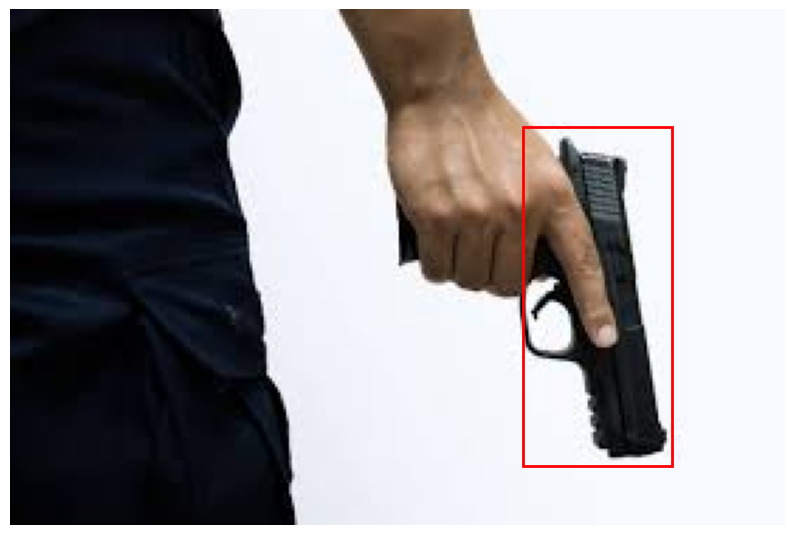

In [10]:
# Step 13: Load Pre-trained Model
def load_model(model_path):
    # Load the pre-trained Faster R-CNN model
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
    num_classes = 2  # Background + Gun
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Load the saved state dictionary
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
    return model

# Step 14: Test on Custom Images Using Saved Model
def predict_image(img_path, model, transform):
    img = Image.open(img_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0)

    with torch.no_grad():
        prediction = model(img_tensor)[0]

    # Plot the image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    for box, label, score in zip(prediction['boxes'], prediction['labels'], prediction['scores']):
        if label == 1 and score > 0.5:  # Gun detected with confidence > 0.5
            box = box.cpu().numpy()
            plt.gca().add_patch(plt.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1],
                                              edgecolor='red', facecolor='none', linewidth=2))
    plt.axis('off')
    plt.show()

# Example Usage for Testing
custom_image_path= os.path.join(custom_test_images_dir, '1.jpg')

# Load the pre-trained model
model = load_model(local_model_path)

# Predict on a custom image
predict_image(custom_image_path, model, get_transform(train=False))